In [39]:
import akshare as ak
import backtrader as bt
import baostock as bs
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tushare as ts

### 策略

In [104]:
class IFStrategy_1(bt.Strategy):
    params = (
        ('printlog', False),
        ('b_per', 20),
        ('b_dev', 2),
        ('pos_max', 10),
    )
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None

        # Add Bollinger Bands indicator
        self.lines.top = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.b_per, 
                                                      devfactor = self.params.b_dev).top
        self.lines.bot = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.b_per, 
                                                      devfactor = self.params.b_dev).bot
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
#                self.log(
#                    'BUY EXECUTED, Price: %.2f, Lot:%i, Cost: %.2f, Comm %.2f, Position:%i, Cash: %i' %
#                    (order.executed.price,
#                     order.executed.size,
#                     order.executed.value,
#                     order.executed.comm,
#                     self.getposition(data).size,
#                     self.broker.get_cash()))
                
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          order.executed.size,
                          self.getposition(data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
#                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cost: %.2f, Comm %.2f, Position:%i, Cash: %i' %
#                         (order.executed.price,
#                          -order.executed.size,
#                          order.executed.value,
#                          order.executed.comm,
#                          self.getposition(data).size,
#                          self.broker.get_cash()))

                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          -order.executed.size,
                          self.getposition(data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))

                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if position size exceeds the limit
        if abs(self.getposition(data).size) > self.params.pos_max:
            # Close short position
            if self.getposition(data).size < 0:
                self.log('BUY CREATE (Close Short), Price: %.2f' % self.dataclose[0])
#                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size = -self.getposition(data).size)
                    
                # Close long position
            if self.getposition(data).size > 0:
                self.log('SELL CREATE (Close Long), Price: %.2f' % self.dataclose[0])
                
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size = self.getposition(data).size)             
        
        lot_ava = (self.broker.get_cash() / 2) //  (data.close[0])

        if (self.dataclose[0] > self.lines.top[0] and self.dataclose[-1] < self.lines.top[-1]) or (self.dataclose[0] > self.lines.bot[0] and self.dataclose[-1] < self.lines.bot[-1]):
            if lot_ava > 0:
                # BUY, BUY, BUY!!!
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size = lot_ava)
            
            else:
                self.log('BUY FAILED (Insufficient Funds)')

        else:

            if  (self.dataclose[0] < self.lines.top[0] and self.dataclose[-1] > self.lines.top[-1]) or (self.dataclose[0] < self.lines.bot[0] and self.dataclose[-1] > self.lines.bot[-1]):
                
                if lot_ava > 0:
                    # SELL, SELL, SELL!!!
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(size = lot_ava)
                elif lot_ava < 0:
                    # SELL, SELL, SELL!!!
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell(size = self.getposition(data).size)
        
    def stop(self):
        self.log('(Period %2d, DevFactor %.2f). Ending Position %i. Ending Value %.2f' %
                 (self.params.b_per, self.params.b_dev, self.getposition(data).size, self.broker.getvalue()), doprint = False)

##### 这个没用到

In [33]:
class HalfCashSizer(bt.Sizer):
    params = (
         ('mult', 10),
     )
    
    def _getsizing(self, comminfo, cash, data, isbuy):
        if (cash / 2) //  (data.close[0]) < 1:
            print('Insufficient Funds!')
            return
        
            return (cash / 3) //  (data.close[0])
            return (cash / 3) //  (data.close[0])

### 数据

In [34]:
ts.set_token('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
pro = ts.pro_api()
s_date = (datetime.datetime.now() - datetime.timedelta(days = 365))
e_date = datetime.datetime.now()
df = pro.fut_daily(ts_code='IFL.CFX', 
                   fields='trade_date,open,high,low,close,vol',
                   start_date=s_date.strftime('%Y%m%d'), end_date=e_date.strftime('%Y%m%d'))
df.index=pd.to_datetime(df.trade_date)
df.drop('trade_date', axis=1, inplace = True)
df = df.astype('float')
df.rename(columns = {'vol':'volume'}, inplace = True)
df['openinterest'] = 0
df = df.iloc[::-1]

### 回测

In [113]:
if __name__ ==  '__main__':
    max_np = 0.0
    max_idx = (0, 0.0)
    for i in range(3, 31, 1):
        for j in np.arange(0.2, 2.1, 0.1):
            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(IFStrategy_1, printlog = False, b_per = i, b_dev = float(j)) 


            # Create a Data Feed
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

            # Add the Data Feed to Cerebo
            cerebro.adddata(data)

            # Set our desired cash start
            cerebro.broker = bt.brokers.BackBroker(coc=True)
            
            cerebro.broker.setcash(100000.00)
            # Set leverage
            cerebro.broker.setcommission(mult = 10)

            # Add a FixedSize sizer according to the stake
            #cerebro.addsizer(HalfCashSizer)

            # Print out the starting conditions\
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            netp = (final_value / start_value -1)*100
            if netp > max_np:
                max_np = netp
                max_idx = (i, j)
print(max_np, max_idx)

118.52599999999956 (21, 2.000000000000001)


In [114]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(IFStrategy_1, printlog = True, b_per = 21, b_dev = 2) 

    # Optimize strategies
    #strats = cerebro.optstrategy(IFStrategy_1, 
    #                             b_per = range(3, 5, 1), 
    #                             b_dev = list(np.arange(0.2, 1, 0.1))) 
    
    # Create a Data Feed
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the Data Feed to Cerebo
    cerebro.adddata(data)
    
    cerebro.broker = bt.brokers.BackBroker(coc=True)        

    # Set our desired cash start
    cerebro.broker.setcash(100000.00)

    # Set leverage
    cerebro.broker.setcommission(mult = 10)

    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(HalfCashSizer)

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Net Profit Rate:%.2f%%' % ((final_value / start_value -1)*100))

2021-11-03: SELL CREATE, 4816.40
2021-11-04: SELL EXECUTED, Price: 4816.40, Lot:10, Position:-10, Cash: 148164, Value: 99528
2021-11-04: BUY CREATE, 4863.60
2021-11-05: BUY EXECUTED, Price: 4863.60, Lot:15, Position:5, Cash: 70961, Value: 95207
2021-11-05: OPERATION PROFIT, GROSS -4720.00, NET -4720.00
2021-12-08: BUY CREATE, 5005.80
2021-12-09: BUY EXECUTED, Price: 5005.80, Lot:7, Position:12, Cash: 35921, Value: 96991
2021-12-09: SELL CREATE (Close Long), Price: 5089.20
2021-12-10: SELL EXECUTED, Price: 5089.20, Lot:12, Position:0, Cash: 112397, Value: 112397
2021-12-10: OPERATION PROFIT, GROSS 17118.00, NET 17118.00
2021-12-14: SELL CREATE, 5059.40
2021-12-15: SELL EXECUTED, Price: 5059.40, Lot:11, Position:-11, Cash: 168051, Value: 112950
2021-12-15: BUY CREATE (Close Short), Price: 5009.20
2021-12-16: BUY EXECUTED, Price: 5009.20, Lot:11, Position:0, Cash: 117919, Value: 117919
2021-12-16: OPERATION PROFIT, GROSS 5522.00, NET 5522.00
2022-01-06: SELL CREATE, 4818.20
2022-01-07: SE

<IPython.core.display.Javascript object>


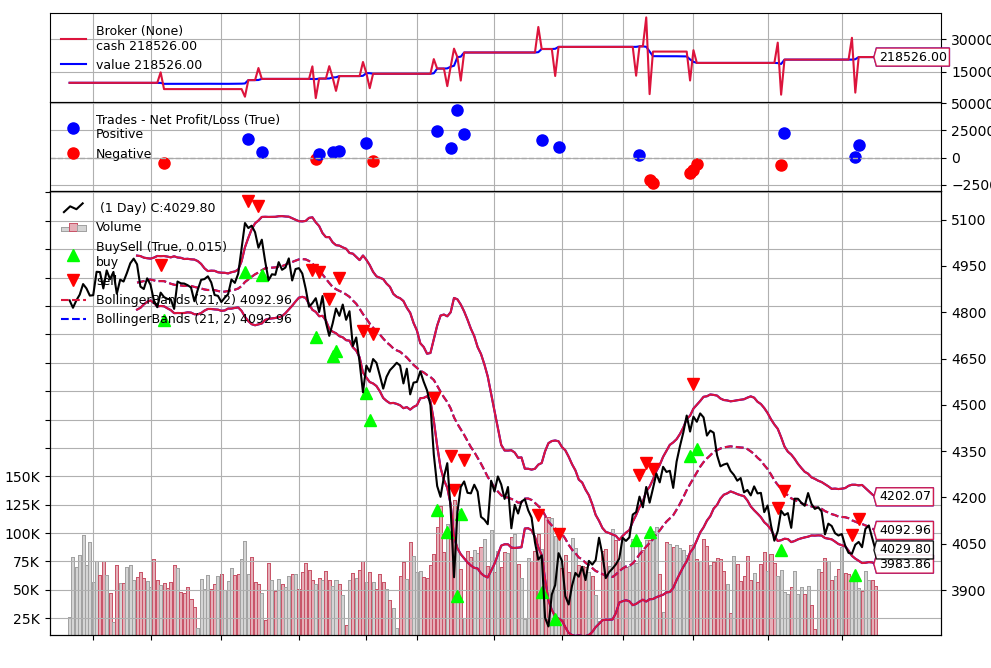

[[<Figure size 640x480 with 4 Axes>]]

In [115]:
cerebro.plot()